In [53]:
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import measure, exposure
from sklearn.preprocessing import MinMaxScaler

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [56]:
from config import *

In [57]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
    
import my_io as io

# Import metadata information

In [58]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

,Pos,Grades,Stage,Directory
0,B1,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1,B3,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2,B5,2,II,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3,C6,AT,AT,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4,D7,3,IIIA,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7


In [59]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [60]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


In [61]:
# Define which dataset to work on 
dataset = datasets[0]

# Get expression level and marker area

In [62]:
df = pd.DataFrame()
df_exp = pd.DataFrame()
for n, dataset in enumerate(datasets):
    imgs, markers = io.read_img(dataset, data_ROI)
    masks = []
    for idx, img in enumerate(imgs):
        blur = cv2.GaussianBlur(img, (5,5),0)
        ret,th = cv2.threshold(blur,40,255,cv2.THRESH_BINARY)
        masks.append(th)

    # Read cell mask image
    cell_mask = io.read_cell_mask(dataset, data_ROI)

    max_cell = len(np.unique(cell_mask))

    # Read mean intensity of marker in cell
    marker_area = {}
    marker_exp = {}
    for idx, marker in enumerate(markers):
#         if marker in ['DNA1', 'DNA2', 'Histone3', 'MHCII']:
#             continue
        mask_marker = cv2.bitwise_and(cell_mask, cell_mask, mask=masks[idx])
        cell_count = len(np.unique(mask_marker)) / max_cell
        marker_area[marker] = [cell_count]
        prop = measure.regionprops_table(
            mask_marker, imgs[idx], properties=["area", "mean_intensity"]
        )
        marker_exp[marker] = [np.mean(prop["mean_intensity"] * prop["area"])]

    df_temp = pd.DataFrame.from_dict(marker_area)
    df_temp["ROI"] = dataset
    df = df.append(df_temp, ignore_index=True)

    df_temp = pd.DataFrame.from_dict(marker_exp)
    df_temp["ROI"] = dataset
    df_exp = df_exp.append(df_temp, ignore_index=True)

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [63]:
df.set_index("ROI", inplace=True)
df.head()

,SMA,Vimentin,PanKeratin,H3K9me3,PDL1,CD44,FoxP3,CD4,ECadherin,CD68,...,PD1,GranzymeB,Ki67,Col1,CD3,Histone3,CD45RO,MHCII,DNA1,DNA2
ROI,,,,,,,,,,,,,,,,,,,,,
ROI001_B1,0.733850,0.261305,0.950581,0.978359,0.798127,0.134044,0.047481,0.023579,0.991925,0.349806,...,0.004522,0.031008,0.047481,0.216408,0.214793,1.000000,0.995801,1.000000,1.0,1.0
ROI005_B3,0.567314,0.764099,0.185264,0.987871,0.455124,0.764706,0.031231,0.125227,0.828684,0.741358,...,0.000606,0.070952,0.223166,0.529412,0.152213,0.999394,0.884172,1.000000,1.0,1.0
ROI006_B5,0.135750,0.186060,0.005059,0.994941,0.018550,0.013210,0.000843,0.000281,0.594435,0.148960,...,0.000281,0.026419,0.225126,0.104553,0.000281,0.998314,0.127319,0.999719,1.0,1.0
ROI007_C6,0.098961,0.839395,0.009447,0.968588,0.004251,0.007085,0.000472,0.001653,0.061408,0.562352,...,0.000236,0.182570,0.010156,0.059046,0.004251,0.996930,0.671705,0.996457,1.0,1.0
ROI008_D7,0.202830,0.732180,0.038784,0.970388,0.001834,0.040356,0.000786,0.000262,0.104560,0.567610,...,0.000262,0.132338,0.063679,0.005503,0.000262,0.995545,0.289832,0.998690,1.0,1.0


In [64]:
df_exp = df_exp.fillna(0)
scaler = MinMaxScaler()
df_exp.set_index("ROI", inplace=True)
scaled_rows = scaler.fit_transform(df_exp.T).T
df_exp = pd.DataFrame(scaled_rows, index=df_exp.index, columns=df_exp.columns)
df_exp.head()

,SMA,Vimentin,PanKeratin,H3K9me3,PDL1,CD44,FoxP3,CD4,ECadherin,CD68,...,PD1,GranzymeB,Ki67,Col1,CD3,Histone3,CD45RO,MHCII,DNA1,DNA2
ROI,,,,,,,,,,,,,,,,,,,,,
ROI001_B1,0.096902,0.157257,0.396607,0.330908,0.102994,0.035160,0.013695,0.017199,0.541916,0.080533,...,0.003786,0.031326,0.042474,0.251275,0.022490,0.974855,0.237045,0.904837,0.791572,1.0
ROI005_B3,0.303656,0.309505,0.021972,0.411334,0.035823,0.075289,0.025774,0.020523,0.219743,0.135967,...,0.000000,0.049869,0.078146,0.220309,0.035087,0.627924,0.113855,0.555695,0.821517,1.0
ROI006_B5,0.209978,0.128789,0.046282,0.621949,0.017068,0.029191,0.008144,0.000000,0.049601,0.092271,...,0.000000,0.071215,0.077686,0.085564,0.000000,0.838405,0.038479,0.680500,0.789855,1.0
ROI007_C6,0.053463,0.107469,0.024712,0.302227,0.052703,0.016085,0.013155,0.012166,0.028841,0.178647,...,0.000000,0.133350,0.040092,0.024013,0.008621,0.514215,0.084539,0.374595,0.828010,1.0
ROI008_D7,0.050926,0.117573,0.035595,0.239434,0.041749,0.018256,0.025845,0.000000,0.020502,0.258911,...,0.000000,0.084835,0.048255,0.015913,0.000000,0.491653,0.047632,0.428867,0.818861,1.0


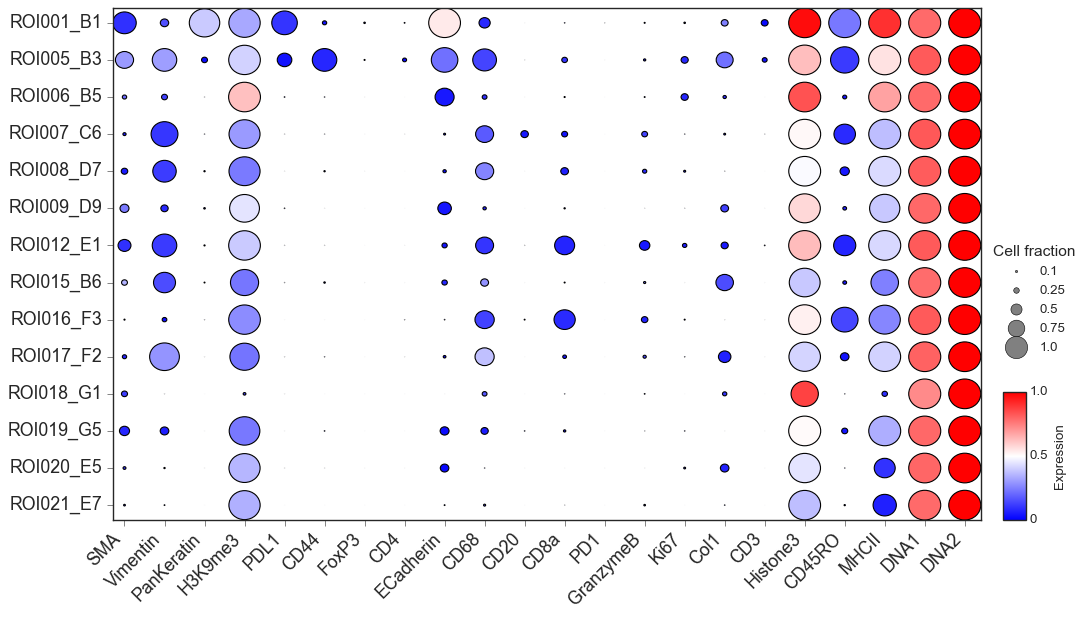

In [65]:
from matplotlib.collections import PatchCollection

plt.style.use("classic")
plt.style.use("seaborn-white")

xlabels = df.columns.tolist()
ylabels = df.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df.values
c = df_exp.values

# Get size and color
R = s / s.max(axis=1)[:, np.newaxis] / 2.5 
circles = [plt.Circle((j, i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")

# Plot image
fig, ax = plt.subplots(figsize=(14, 8))
ax.add_collection(col)
ax.set( 
    xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels
)
ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.tick_params(which="major", length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", "0.5", "1.0"])
cbar.set_label("Expression")

# Size legend
h = [
    ax.plot([], [], color="gray", marker="o", ms=i * 2, ls="", label=i / 10)[0]
    for i in [1, 2.5, 5, 7.5, 10]
]
leg = ax.legend(
    handles=h, loc="lower left", bbox_to_anchor=(1.0, 0.3, 0.02, 0.4), fontsize="medium"
)
leg.set_title("Cell fraction", prop={"size": 14})

plt.show()

In [66]:
df = df.drop(['DNA1', 'DNA2', 'Histone3', 'MHCII', 'H3K9me3'], axis=1)

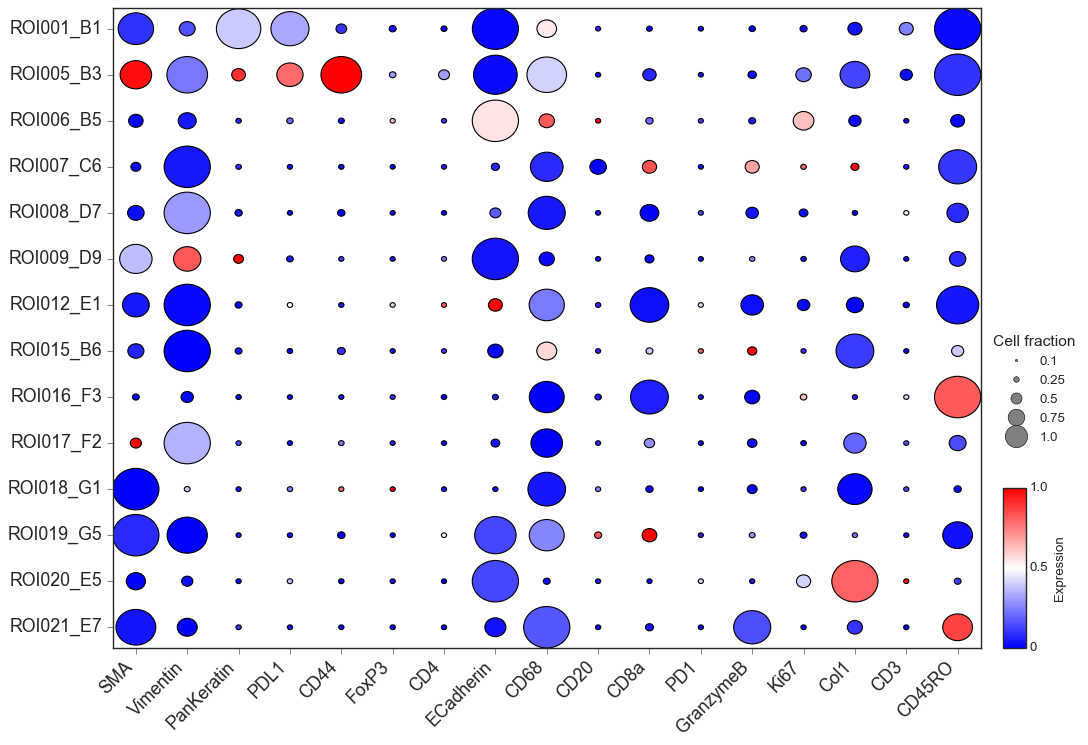

In [75]:
from matplotlib.collections import PatchCollection

plt.style.use("classic")
plt.style.use("seaborn-white")

xlabels = df.columns.tolist()
ylabels = df.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df.values
c = df_exp.values

# Get size and color
R = s / s.max(axis=1)[:, np.newaxis] / 2.5 
circles = [plt.Circle((j, i), radius=r+0.05) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")

# Plot image
fig, ax = plt.subplots(figsize=(14, 10))
ax.add_collection(col)
ax.set( 
    xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels
)
ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.tick_params(which="major", length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", "0.5", "1.0"])
cbar.set_label("Expression")

# Size legend
h = [
    ax.plot([], [], color="gray", marker="o", ms=i * 2, ls="", label=i / 10)[0]
    for i in [1, 2.5, 5, 7.5, 10]
]
leg = ax.legend(
    handles=h, loc="lower left", bbox_to_anchor=(1.0, 0.3, 0.02, 0.4), fontsize="medium"
)
leg.set_title("Cell fraction", prop={"size": 14})

plt.show()